In [1]:
from setup_triton import setup_triton

# TRITON_INTERPRET=1 uses a python interpreter instead of running on the GPU. 
# This menas that uou can insert Python breakpoints to debug your kernel code! 
setup_triton(use_interpreter=False)

# Triton Puzzle 3: Fused Entmax

Welcome to the third Triton puzzle! Now we'll tackle a more complex operation: fused entmax. 

### What you'll learn:
- How entmax can be computed via the bisection algorithm
- How it can be parallelized in Triton


## Mathematical Background

The $\alpha$-entmax mapping is given by:
$$
{\alpha\text{-entmax}(x)}_i = \max\left(0, (\alpha - 1)x_i - \tau\right)^{\frac{1}{\alpha-1}} 
$$

Thus, for one to calculate entmax, one requires to find $\tau$ that satistfies $\sum_i \max\left(0, (\alpha - 1)x_i - \tau\right)^{\frac{1}{\alpha-1}} = 1$, that is, that satisfies that the sum of all entries sums to one. $[x]_+$ represents $\max(x, 0)$.

Let us define the function $f(\tau)$ for which we are trying to find the root for:
$$
f(\tau) = \sum_i \max\left(0, (\alpha - 1)x_i - \tau \right)^{\frac{1}{\alpha-1}} - 1
$$

Currently, in the entmax package (`pip install entmax`) the algorithm to calculate this $\tau$ for an arbitrary $\alpha$ makes use of the bisection algorithm. A high-level description of the bisection algorithm goes like this:


<table>
    <tr>
        <td>
            $$
            \begin{align*}
            \text{Input: }& x \in \mathbb{R}^n, \alpha \in \mathbb{R}, T \text{ iterations} \\
            \text{(1): }& m \leftarrow \max((\alpha-1)x) \\ 
            \text{(2): }& \text{Initialize } \tau_\text{lo} = m - 1,\tau_\text{hi} = m - n^{1-\alpha}, \tau = \frac{\tau_\text{lo} + \tau_\text{hi}}{2} \\
            \text{(3): }& \text{For t in T iterations do:} \\
            &\quad\text{Compute } f(\tau) \\
            &\quad\text{If } f(\tau) > 0: \tau_\text{lo} = \tau \text{ else } \tau_\text{hi} = \tau \\
            &\quad\tau \leftarrow \frac{\tau_\text{lo} + \tau_\text{hi}}{2} \\
            \text{(4): }& \text{Store element-wise }  \max\left(0, (\alpha - 1)x_i - \tau\right)^{\frac{1}{\alpha-1}} \\
            \end{align*}
            $$
        </td>
        <td>
            <img src="https://upload.wikimedia.org/wikipedia/commons/8/8c/Bisection_method.svg" width="256" />
        </td>
    </tr>
</table>



In [2]:
import torch
import triton
import triton.language as tl
import numpy as np
from IPython.display import display, Image

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seed
torch.manual_seed(42)

Using device: cuda


## Implemention 1: Naive PyTorch

In [29]:
def entmax_transform(x, tau, alpha):
    return torch.relu(x - tau) ** (1 / (alpha - 1))

def entmax_naive(z, alpha=1.5, dim=-1, n_iter=50):
    x = (alpha - 1) * z
    max_val = x.max()
    tau_lower = max_val - 1
    tau_upper = max_val - x.size(0) ** (1 - alpha)
    for _ in range(n_iter):
        tau = (tau_lower + tau_upper) / 2
        p = entmax_transform(x, tau, alpha)  # Creates intermediate tensor!
        if p.sum() > 1:  # Read entire p to compute sum
            tau_lower = tau
        else:
            tau_upper = tau
    p = entmax_transform(x, tau, alpha)
    return p

## Implementation 2: entmax package

The [entmax](https://github.com/deep-spin/entmax) package implements the bisection version of entmax (general alpha) and specialized versions for alpha=1.5 and alpha=2.0 (sparsemax)

In [7]:
#!pip install entmax
from entmax import entmax_bisect, entmax15, sparsemax

## Implementation 3: PyTorch Compiled

Let's see if torch.compile can fuse our naive implementation:

In [30]:
@torch.compile
def entmax_transform_compiled(x, tau, alpha):
    return torch.relu(x - tau) ** (1 / (alpha - 1))

@torch.compile
def entmax_compiled(z, alpha=1.5, dim=-1, n_iter=50):
    x = (alpha - 1) * z
    max_val = x.max()
    tau_lower = max_val - 1
    tau_upper = max_val - x.size(0) ** (1 - alpha)
    for _ in range(n_iter):
        tau = (tau_lower + tau_upper) / 2
        p = entmax_transform_compiled(x, tau, alpha)  # Creates intermediate tensor!
        if p.sum() > 1:  # Read entire p to compute sum
            tau_lower = tau
        else:
            tau_upper = tau
    p = entmax_transform_compiled(x, tau, alpha)
    return p

## Implementation 4: Triton Kernel (Puzzle)

Assume the following:
- The input is a matrix $b \times n$, and we want to perform the entmax transformation along the last dimension. 
- $n$ is a power of two, so no masking is required.

### Your Task:
Complete the kernel to:
1. Load a row of data (handling the case where row > BLOCK_SIZE)
2. Find the maximum value in the row
3. Compute `n_iter` iterations of bisection to find `tau` (load blocks for each iteration)
4. Reload once again and compute entmax with `tau` found from the previous step.
5. Store the result

To help you out, we provide a `alpha_entmax` kernel, which you can use to compute $\max(0, (\alpha-1)x)^{1/(\alpha-1)}$ element-wise.


In [9]:
@triton.jit
def alpha_entmax(x, tau, alpha):
    x = (alpha - 1) * x - tau
    # x^c = exp_b (c log_b(x) )
    x = tl.where(x > 0, tl.exp2(1 / (alpha - 1) * tl.log2(x)), 0.0)
    return x


@triton.jit
def _ent_bisect(x_ptr, y_ptr, alpha, n_iter, N: tl.constexpr, TILE: tl.constexpr):
    
    # get row that this thread block will be responsible for
    curr_row = tl.program_id(0)

    # move pointers to the start of the input and output tensors
    x_ptr += curr_row * N
    y_ptr += curr_row * N

    # same as torch.arange
    offsets = tl.arange(0, TILE)

    # YOUR IMPLEMENTATION GOES HERE
    # 1) Calculate the maximum row-wise
    # 2) Run bisection `n_iter` times to find tau (be careful about possible NaNs!).
    # 3) Finally apply the entmax function with tau and store the result.
    pass


def entmax_triton(x, alpha=1.5, n_iter=50):
    rows, cols = x.shape
    assert cols.bit_count() == 1, "We require the number of columns to be a power of 2."
    TILE = 1024 if cols > 1024 else cols

    # launch with as many programs as rows in x
    grid = (rows,)

    # allocate output tensor
    y = torch.empty_like(x)

    # launch the kernel
    _ent_bisect[grid](x, y, alpha, n_iter, cols, TILE)

    return y

## Solution üßô

In [10]:
# Our implementations goes here

## Testing Correctness

Verify our implementation matches PyTorch:

‚úÖ Test PASSED! Results match within tolerance.
   Shape tested: (100, 2048)
   Max absolute difference: 1.64e-07

üéâ Congratulations! Your implementation is correct!


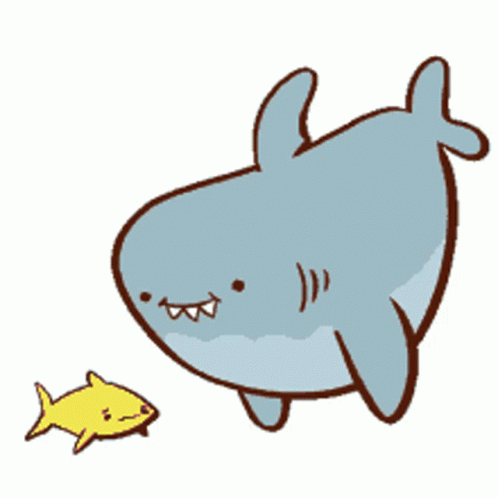

In [11]:
def test_correctness(n_rows=100, n_cols=2048, atol=1e-5, rtol=1e-5):
    """Test if Triton implementation matches PyTorch."""
    torch.manual_seed(42)

    b, n = 16, 4096 * 2
    alpha = 1.5
    n_iter = 50
    
    x = torch.randn((b, n), device=DEVICE, dtype=torch.float32).contiguous()
    
    # Compute with PyTorch
    expected = entmax_bisect(x, alpha=alpha, n_iter=n_iter)
    
    # Compute with Triton
    actual = entmax_triton(x, alpha=alpha, n_iter=n_iter)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"‚úÖ Test PASSED! Results match within tolerance.")
        print(f"   Shape tested: ({n_rows}, {n_cols})")
        print(f"   Max absolute difference: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"‚ùå Test FAILED!")
        print(f"   Error: {e}")
        return False

# Run tests
test_passed = test_correctness()

# Display congrats message
if test_passed:
    print("\nüéâ Congratulations! Your implementation is correct!")
    display(Image("./figs/success.gif", width=256, height=256))

## FLOP and Memory Analysis

Let's analyze the computational complexity:

In [13]:
def analyze_entmax_ops(n_rows, n_cols, n_iter=50, alpha=1.5):
    """Analyze operations for entmax computation using bisection."""
    
    # FLOPs per element for alpha_entmax transformation:
    # (alpha-1) * x:    1 multiplication
    # - subtract tau:   1 subtraction
    # - x > 0:          1 comparison
    # - log2(x):        ~10 FLOPs (for positive values)
    # - * 1/(alpha-1):  1 multiplication
    # - exp2:           ~10 FLOPs (for positive values)
    # Assuming ~50% sparsity on average
    
    log2_flops = 10
    exp2_flops = 10
    sparsity = 0.5  # Approximate fraction of non-zero values
    
    entmax_flops_per_element = (
        1 +  # (alpha-1) * x
        1 +  # subtract tau
        1 +  # comparison
        sparsity * (log2_flops + 1 + exp2_flops)  # power operation for non-zeros
    )
    
    # FLOPs per row:
    # 1. Finding max:  n_cols comparisons
    # 2. Bisection (n_iter iterations):
    #    - Compute entmax:   n_cols * entmax_flops_per_element
    #    - Sum: n_cols additions
    #    - Update tau: 3 ops (comparison, assignment, average)
    # 3. Final entmax application: n_cols * entmax_flops_per_element
    
    flops_per_row = (
        n_cols +  # max
        n_iter * (
            n_cols * entmax_flops_per_element +  # entmax computation
            n_cols +  # sum
            3  # tau update
        ) +
        n_cols * entmax_flops_per_element  # final entmax
    )
    
    total_flops = n_rows * flops_per_row
    
    # Memory operations (in bytes)
    element_size = 4  # float32

    # Naive PyTorch implementation would look like:
    # max_val = x.max()
    # for _ in range(n_iter):
    #     p = entmax_transform(x, tau, alpha)  # Creates intermediate tensor!
    #     if p.sum() > 1:  # Read entire p to compute sum
    #         tau_lower = tau
    #     else:
    #         tau_upper = tau
    #     tau = (tau_lower + tau_upper) / 2
    # output = entmax_transform(x, tau, alpha)
    
    naive_mem_ops = {
        'reads': n_rows * n_cols * element_size * (
            1 +           # Read x for max
            n_iter * 2 +  # Each iter: read x for transform, read p for sum
            1             # Final read of x
        ),
        'writes': n_rows * n_cols * element_size * (
            n_iter +  # Write intermediate p tensors
            1         # Write final output
        ),
        'total': n_rows * n_cols * element_size * (3 * n_iter + 3)
    }
    
    # Fused Triton implementation:
    # Everything stays in SRAM, but we still do multiple passes over input
    fused_mem_ops = {
        'reads': n_rows * n_cols * element_size * (
            1 +          # Read for max (could be fused with first iter)
            n_iter +     # Read x once per iteration
            1            # Final read for output
        ),
        'writes': n_rows * n_cols * element_size * 1,  # Write output once
        'total': n_rows * n_cols * element_size * (n_iter + 3)
    }
    
    
    # For comparison with a hypothetical single-pass algorithm
    optimal_mem_ops = {
        'reads': n_rows * n_cols * element_size * 1,
        'writes': n_rows * n_cols * element_size * 1,
        'total': n_rows * n_cols * element_size * 2
    }
    
    return {
        'flops': total_flops,
        'flops_per_element': flops_per_row / n_cols,
        'naive_memory': naive_mem_ops,
        'fused_memory': fused_mem_ops,
        'optimal_memory': optimal_mem_ops,
        'memory_reduction': naive_mem_ops['total'] / fused_mem_ops['total'],
        'arithmetic_intensity': total_flops / fused_mem_ops['total']  # FLOPs per byte
    }

# Example analysis
n_rows, n_cols = 2048, 4096
n_iter = 50
alpha = 1.5

analysis = analyze_entmax_ops(n_rows, n_cols, n_iter, alpha)

print(f"Entmax analysis for {n_rows}x{n_cols} matrix with {n_iter} iterations:")
print(f"  Total FLOPs: {analysis['flops']:,}")
print(f"  FLOPs per element: {analysis['flops_per_element']:.1f}")
print(f"\nMemory traffic:")
print(f"  Naive implementation: {analysis['naive_memory']['total'] / 1e9:.2f} GB")
print(f"  Fused Triton kernel: {analysis['fused_memory']['total'] / 1e9:.2f} GB")
print(f"  Theoretical optimal: {analysis['optimal_memory']['total'] / 1e9:.2f} GB")
print(f"\nEfficiency metrics:")
print(f"  Memory reduction vs naive: {analysis['memory_reduction']:.2f}x")
print(f"  Arithmetic intensity: {analysis['arithmetic_intensity']:.1f} FLOPs/byte")

Entmax analysis for 2048x4096 matrix with 50 iterations:
  Total FLOPs: 6,203,682,816.0
  FLOPs per element: 739.5

Memory traffic:
  Naive implementation: 5.13 GB
  Fused Triton kernel: 1.78 GB
  Theoretical optimal: 0.07 GB

Efficiency metrics:
  Memory reduction vs naive: 2.89x
  Arithmetic intensity: 3.5 FLOPs/byte


## Summary

In this tutorial, you learned:

1. **Bisection Algorithm**: How to implement root-finding algorithms in parallel on GPUs
2. **Multi-pass Kernels**: Processing data multiple times to find global statistics
3. **Sparse Activations**: Understanding entmax as a sparse alternative to softmax
4. **Numerical Stability**: Using `exp2` and `log2` to handle power operations safely

### Key Insights:

- **Algorithm Parallelization**: Each row's $\tau$ can be computed independently
- **Memory Efficiency**: All bisection iterations stay in fast SRAM!
- **Tiling Strategy**: Processing large vectors in `BLOCK_SIZE` chunks
- **Sparse Outputs**: Unlike softmax, entmax can produce exact zeros. Can we leverage this?


### Performance Tips:

- Use enough bisection iterations (20-50) for convergence
- Choose `BLOCK_SIZE` based on your typical sequence lengths
- Pre-compute multiplications when possible


Next puzzle: matmul!

<img src="./figs/sardine-challenge.png" width="512" />

---

## Benchmarking (GPU only)

Below you can check how well your solution performs against entmax's package.

Running benchmarks...
entmax-performance:
    n_cols      Naive    PyTorch   Compiled    Triton
0    128.0   1.858016   3.018720   3.107392  0.032768
1    256.0   1.902368   3.033520   3.752480  0.028736
2    512.0   1.889984   3.008784   3.754272  0.042944
3   1024.0   1.906896   3.015296   3.731232  0.070080
4   2048.0   3.235904   3.010736   3.826240  0.145600
5   4096.0   5.525504   4.924000   4.644864  0.545216
6   8192.0   9.992928   9.326928   6.590528  1.289952
7  16384.0  18.955296  18.075647  10.462048  2.591184


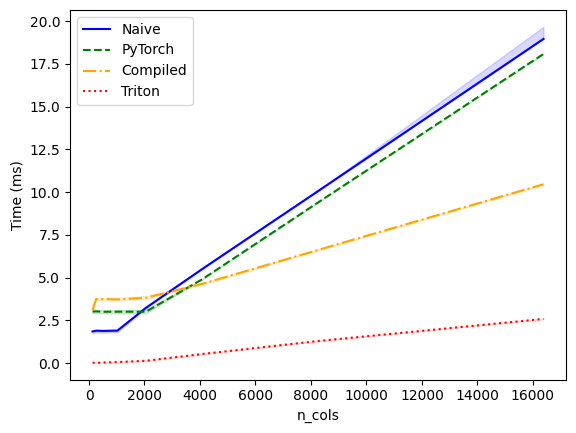

In [31]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n_cols'],  # Column size as x-axis
        x_vals=[128, 256, 512, 1024, 2048, 4096, 8192, 16384],
        line_arg='provider',
        line_vals=['naive', 'pytorch', 'compiled', 'triton'],
        line_names=['Naive', 'PyTorch', 'Compiled', 'Triton'],
        styles=[('blue', '-'), ('green', '--'), ('orange', '-.'), ('red', ':')],
        ylabel='Time (ms)', 
        plot_name='entmax-performance',
        args={'n_rows': 1024},  # Fix number of rows
    )
)
def benchmark(n_rows, n_cols, provider):
    """Benchmark softmax implementations."""
    x = torch.randn(n_rows, n_cols, device=DEVICE, dtype=torch.float32)
    
    quantiles = [0.5, 0.05, 0.95]

    alpha = 1.5
    n_iter = 20
    
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: entmax_naive(x, alpha=alpha, n_iter=n_iter), quantiles=quantiles
        )
    elif provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: entmax_bisect(x, alpha=alpha, n_iter=n_iter), quantiles=quantiles
        )
    elif provider == 'compiled':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: entmax_compiled(x, alpha=alpha, n_iter=n_iter), quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: entmax_triton(x, n_iter=n_iter), quantiles=quantiles
        )

    return ms, max_ms, min_ms

# Run benchmarks
print("Running benchmarks...")
results = benchmark.run(print_data=True, return_df=True, save_path='')

## Speedup?


üöÄ Awesome! Triton is 9.99x faster than PyTorch!


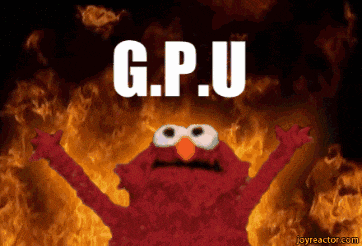

In [33]:
# Check if Triton is faster than PyTorch
avg_pytorch = results['PyTorch'].mean()
avg_triton = results['Triton'].mean()
speedup = avg_pytorch / avg_triton

if speedup > 1.0:
    print(f"\nüöÄ Awesome! Triton is {speedup:.2f}x faster than PyTorch!")
    display(Image("./figs/gpu.gif", width=400, height=256))
else:
    print(f"\nüêå Not quite yet! Triton implementation is {speedup:.2f}x slower than PyTorch!")